In [7]:
!python --version

Python 3.6.8 :: Anaconda, Inc.


### Predicting Customer Churn

### Environment Setup

In [8]:
#Uncomment and run once to install the wget package in your runtime environment
!pip install wget

  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [9]:
#Uncomment and run once to install the package in your runtime environment
!pip install pandas_profiling

     |████████████████████████████████| 133kB 19.4MB/s eta 0:00:01
     |████████████████████████████████| 614kB 24.7MB/s eta 0:00:01


  Stored in directory: /home/dsxuser/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Stored in directory: /home/dsxuser/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Stored in directory: /home/dsxuser/.cache/pip/wheels/b0/b2/96/2074eee7dbf7b7df69d004c9b6ac4e32dad04fb7666cf943bd
Successfully built pandas-profiling htmlmin confuse


In [10]:
#Uncomment and run once to install the package in your runtime environment
!pip install sklearn-pandas

In [11]:
#Uncomment and run once to install the package in your runtime environment
!pip install watson-machine-learning-client --upgrade

     |████████████████████████████████| 542kB 19.2MB/s eta 0:00:01
  Found existing installation: watson-machine-learning-client 1.0.376
    Uninstalling watson-machine-learning-client-1.0.376:
      Successfully uninstalled watson-machine-learning-client-1.0.376


In [12]:
import wget
import pandas as pd
import numpy as np
import pandas_profiling
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import json
import matplotlib.pyplot as plt
%matplotlib inline


### Step 1: Load data 

#### 1.1: Download the data files

In [14]:
# download data from GitHub repository

url_churn='https://raw.githubusercontent.com/SidneyPhoon/Data/master/churn.csv'

url_customer='https://raw.githubusercontent.com/SidneyPhoon/Data/master/customer-profile.csv'

#remove existing files before downloading
!rm -f churn.csv
!rm -f customer-profile.csv

churnFilename=wget.download(url_churn)
customerFilename=wget.download(url_customer)

#list existing files
!ls -l churn.csv
!ls -l customer-profile.csv

-rw-r----- 1 dsxuser dsxuser 8546 Nov 20 17:23 churn.csv
-rw-r----- 1 dsxuser dsxuser 77821 Nov 20 17:23 customer-profile.csv


In [15]:
customer_churn = pd.read_csv('churn.csv')
customer = pd.read_csv('customer-profile.csv')

### Step 2: Merge Files

In [16]:
data = pd.merge(customer, customer_churn, on='ID')

### Step 3: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may want to do before creating a model. 

In [17]:
data.columns

Index(['ID', 'Gender', 'Status', 'Children', 'Est Income', 'Car Owner', 'Age',
       'AvgMonthlySpend', 'CustomerSupportCalls', 'Paymethod',
       'MembershipPlan', 'CHURN'],
      dtype='object')

In [18]:
data.rename(columns={'Est Income':'EstIncome', 'Car Owner':'CarOwner' }, inplace=True)

In [19]:
data.head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,AvgMonthlySpend,CustomerSupportCalls,Paymethod,MembershipPlan,CHURN
0,11,M,S,2.0,96.33,N,56.473333,32.88,1.0,CC,1.0,F
1,22,M,S,1.0,57626.90,Y,43.906667,38.96,0.0,CC,2.0,F
2,23,M,M,2.0,20078.00,N,32.846667,6.33,0.0,CC,4.0,F
3,35,F,S,0.0,78851.30,N,48.373333,28.66,0.0,CC,4.0,T
4,36,F,S,1.0,17540.70,Y,62.786667,13.45,0.0,Auto,4.0,T


In [20]:
data.shape

(785, 12)

### Step 4: Data understanding

In [21]:
data.describe()

,ID,Children,EstIncome,Age,AvgMonthlySpend,CustomerSupportCalls,MembershipPlan
count,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000
mean,1962.872611,1.131210,49411.709108,42.062616,59.886841,0.114650,2.508280
std,1090.896925,0.831066,30976.276910,15.226786,57.342251,0.456922,1.157383
min,11.000000,0.000000,96.330000,12.326667,0.790000,0.000000,1.000000
25%,1046.000000,0.000000,19749.300000,27.746667,14.380000,0.000000,1.000000
50%,1982.000000,1.000000,49910.700000,45.360000,39.620000,0.000000,2.000000
75%,2871.000000,2.000000,76161.400000,54.013333,87.880000,0.000000,4.000000
max,3824.000000,2.000000,120000.000000,77.000000,332.460000,4.000000,4.000000


In [22]:
pandas_profiling.ProfileReport(data)

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: Us

### Step 5: Build the sklearn pipeline and the Random Forest model


In [23]:
# Define input data to the model
X = data.drop(['ID','CHURN'], axis=1)

In [24]:
# Define the target variable and encode with value between 0 and n_classes-1, that is from T/F to 1/0
le = LabelEncoder()
y = le.fit_transform(data['CHURN'])

In [31]:
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  F
1:  T


In [32]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

#### Use the DataFrameMapper class to declare transformations and variable imputations.

* LabelBinarizer - Converts a categorical variable into a dummy variable (aka binary variable)
* StandardScaler - Standardize features by removing the mean and scaling to unit variance, z = (x - u) / s

See docs: 
* https://github.com/scikit-learn-contrib/sklearn-pandas
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [33]:

mapper_good = DataFrameMapper([
    (['Gender'], LabelBinarizer()),
    (['Status'], LabelBinarizer()),
    (['CarOwner'], LabelBinarizer()),
    (['Paymethod'], LabelBinarizer()),
    (['MembershipPlan'], LabelBinarizer()),
    (['Children'],  StandardScaler()),
    (['EstIncome'],  StandardScaler()),
    (['Age'],  StandardScaler()),
    (['AvgMonthlySpend'],  StandardScaler()),
    (['CustomerSupportCalls'],  StandardScaler())], default=False)


In [34]:
# Instantiate the Classifier
random_forest = RandomForestClassifier(random_state=5)

# Define the steps in the pipeline to sequentially apply a list of transforms and the estimator, i.e. RandomForestClassifier
steps = [('mapper', mapper_good),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)

# train the model
model=pipeline.fit( X_train, y_train )

model

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['Gender'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), (['Status'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), (['CarOwner'], LabelBinarizer(neg_label=0, pos_label=1, sparse_ou...imators=10, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])

In [35]:
# Display Label Mapping to assist with interpretation of the model
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  F
1:  T


In [36]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )

### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )

### and print the report
print(report)

              precision    recall  f1-score   support

           0       0.71      0.81      0.76       127
           1       0.74      0.61      0.67       109

   micro avg       0.72      0.72      0.72       236
   macro avg       0.72      0.71      0.71       236
weighted avg       0.72      0.72      0.72       236



###  Step 6:  Tune the model to find the best model

In [37]:
# List keys to the model param to tune
#model.get_params().keys()

In [38]:
parameters = { 'RandonForestClassifier__max_depth': [5,8,10],
               'RandonForestClassifier__n_estimators': [150,180,200]}

In [39]:
grid_obj = GridSearchCV(estimator=model, param_grid=parameters,  cv=3)

In [40]:
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)


In [41]:
# Get the estimator
best_clf = grid_fit.best_estimator_

In [42]:
best_predictions = best_clf.predict(X_test)

In [43]:
best_predictions_report = sklearn.metrics.classification_report( y_test, best_predictions )

In [44]:
print('Results of best fitted model: \n\n',best_predictions_report)

Results of best fitted model: 

               precision    recall  f1-score   support

           0       0.75      0.82      0.78       127
           1       0.76      0.68      0.72       109

   micro avg       0.75      0.75      0.75       236
   macro avg       0.76      0.75      0.75       236
weighted avg       0.75      0.75      0.75       236



In [45]:
print('Results of default model: \n\n',report)

Results of default model: 

               precision    recall  f1-score   support

           0       0.71      0.81      0.76       127
           1       0.74      0.61      0.67       109

   micro avg       0.72      0.72      0.72       236
   macro avg       0.72      0.71      0.71       236
weighted avg       0.72      0.72      0.72       236



In [46]:
m_step=pipeline.named_steps['mapper']

In [47]:
m_step.transformed_names_

['Gender',
 'Status_D',
 'Status_M',
 'Status_S',
 'CarOwner',
 'Paymethod_Auto',
 'Paymethod_CC',
 'Paymethod_CH',
 'MembershipPlan_1.0',
 'MembershipPlan_2.0',
 'MembershipPlan_3.0',
 'MembershipPlan_4.0',
 'Children',
 'EstIncome',
 'Age',
 'AvgMonthlySpend',
 'CustomerSupportCalls']

In [48]:
features = m_step.transformed_names_

In [49]:
# Get the features importance
importances = pipeline.named_steps['RandonForestClassifier'][1].feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


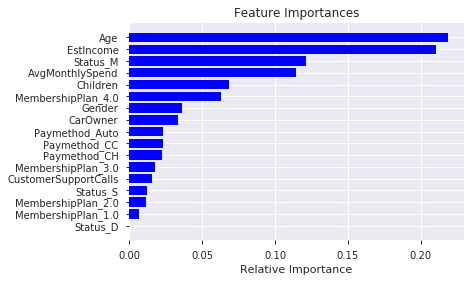

In [50]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

### Step 7: Save Model in WML repository

In this section you will store your model in the Watson Machine Learning (WML) repository by using Python client libraries.
* <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-overview.html?context=analytics">WML Documentation</a>
* <a href="http://watson-ml-api.mybluemix.net/">WML REST API</a> 
* <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deploy-notebook.html?audience=wdp&context=analytics&linkInPage=true">Deploy a model from a notebook</a>
* <a href="https://wml-api-pyclient.mybluemix.net/">WML Repository API</a>
<br/>

You must have imported client libraries from pypi.

In [38]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

#### <span style="color:red">7.1 Action Required</span>

If you do not already have an instance of the Machine Learning service in IBM Cloud, go to <a href="https://console.ng.bluemix.net/dashboard/apps/" target="_blank">IBM Cloud</a>, click **Catalog** on the top right of the menu, search for "Machine Learning", and create an instance.

If you have an existing instance of the Machine Learning service in <a href="https://console.ng.bluemix.net/dashboard/apps/" target="_blank">IBM Cloud</a>, click into the service.


#### <span style="color:red">7.2 Action Required</span>

* Click **Service credentials** on the left navigation bar
* Click **New credentials** and then the **Add** button to create new credentials
* Under **ACTIONS** click **View credentials**
* Click the **copy** icon to copy the credentials
* Paste the credentials into the code cell below

Paste credentials in the code cell below

In [39]:
# @hidden_cell
wml_credentials={
  ......
}

#### Create API client by running below code.

In [40]:
wml_client = WatsonMachineLearningAPIClient(wml_credentials)

#### 7.3 Publish model in Watson Machine Learning repository on Cloud.

In [41]:
model_props = {wml_client.repository.ModelMetaNames.AUTHOR_NAME: "Sidney Phoon",  
               wml_client.repository.ModelMetaNames.NAME: "Predict Customer Churn - sklearn"}

published_model = wml_client.repository.store_model(model=best_clf, pipeline=pipeline, meta_props=model_props, training_data=X_train, training_target=y_train)

In [42]:
# get model details
import json
published_model_uid = wml_client.repository.get_model_uid(published_model)
model_details = wml_client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "metadata": {
    "guid": "229b009c-e802-4add-8ba7-a89bc5ea7406",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/7d184276-32ca-433c-8662-0e0660e53f65/published_models/229b009c-e802-4add-8ba7-a89bc5ea7406",
    "created_at": "2019-11-20T01:39:07.954Z",
    "modified_at": "2019-11-20T01:39:08.020Z"
  },
  "entity": {
    "runtime_environment": "python-3.6",
    "learning_configuration_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/7d184276-32ca-433c-8662-0e0660e53f65/published_models/229b009c-e802-4add-8ba7-a89bc5ea7406/learning_configuration",
    "author": {
      "name": "Sidney Phoon"
    },
    "name": "Predict Customer Churn - sklearn",
    "label_col": "l1",
    "learning_iterations_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/7d184276-32ca-433c-8662-0e0660e53f65/published_models/229b009c-e802-4add-8ba7-a89bc5ea7406/learning_iterations",
    "training_data_schema": {
      "features": {
        "type": "DataFrame",
        "fields": [
  

In [43]:
#List all models
wml_client.repository.list_models()

------------------------------------  ---------------------------------------  ------------------------  -----------------
GUID                                  NAME                                     CREATED                   FRAMEWORK
229b009c-e802-4add-8ba7-a89bc5ea7406  Predict Customer Churn - sklearn         2019-11-20T01:39:07.954Z  scikit-learn-0.20
7ccea5b4-da5f-43e4-ad70-7bc31c2e4dc0  Predict Customer Churn - SparkML - 1017  2019-10-17T22:54:36.443Z  mllib-2.3
867c00c9-c966-4774-a956-3a89586cc0a4  MNIST - compressed keras model           2019-09-26T19:43:57.242Z  tensorflow-1.5
dae1ec32-8b8f-4458-9b60-9c25f34c2f29  Predict Customer Churn-Modeler Flow      2019-07-23T19:12:07.493Z  spss-modeler-18.1
------------------------------------  ---------------------------------------  ------------------------  -----------------


### Step 8: Deploy and score in a Cloud
In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning Client.

#### 8.1 Create online deployment

In [44]:
created_deployment = wml_client.deployments.create(published_model_uid, name="Predict Customer Churn Py36 sklearn Online Deployment")



#######################################################################################

Synchronous deployment creation for uid: '229b009c-e802-4add-8ba7-a89bc5ea7406' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='8a697f85-76b4-4627-884a-26f49f55955d'
------------------------------------------------------------------------------------------------




In [45]:
scoring_endpoint = wml_client.deployments.get_scoring_url(created_deployment)

print('Scoring Endpoint:   ',scoring_endpoint)

Scoring Endpoint:    https://us-south.ml.cloud.ibm.com/v3/wml_instances/7d184276-32ca-433c-8662-0e0660e53f65/deployments/8a697f85-76b4-4627-884a-26f49f55955d/online


In [46]:
#scoring_endpoint = 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/7d184276-32ca-433c-8662-0e0660e53f65/deployments/967c225d-6f3d-4632-b632-f6b784a9bda5/online'

#### 8.2 Get deployments

In [47]:
wml_client.deployments.list()

------------------------------------  -----------------------------------------------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME                                                   TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
8a697f85-76b4-4627-884a-26f49f55955d  Predict Customer Churn Py36 sklearn Online Deployment  online  DEPLOY_SUCCESS  2019-11-20T01:39:13.135Z  scikit-learn-0.20  model
1e1235ce-0422-4ded-a65e-e85a1586e440  Predict-Customer_Attrition-SparkML-Deploy              online  DEPLOY_SUCCESS  2019-10-17T22:55:54.593Z  mllib-2.3          model
2cec1856-11dd-46d8-a704-0f49a4224837  predict-churn-flow-online                              online  DEPLOY_SUCCESS  2019-07-23T23:18:26.455Z  spss-modeler-18.1  model
------------------------------------  -----------------------------------------------------  ------  --------------  ------------------------  -

#### 8.3 Score
You can use below method to test scoring request against deployed model.

In [66]:
scoring_payload = {
    "fields": [
    "Gender",
    "Status",
    "Children",
    "EstIncome",
    "CarOwner",
    "Age",
    "AvgMonthlySpend",
    "CustomerSupportCalls",
    "Paymethod",
    "MembershipPlan"
    ],
    "values": [ ["M","S",2.0,55000,"Y",45,10,1,"CC",1] ]
} 

In [67]:
predictions = wml_client.deployments.score(scoring_endpoint, scoring_payload)

In [68]:
predictions

{'fields': ['prediction', 'probability'],
 'values': [[0, [0.7240211640211641, 0.27597883597883605]]]}

In [69]:
# get the predicted value and reverse the label transformation
predicted_value = predictions.get('values')[0][0]
le.inverse_transform([predicted_value])

array(['F'], dtype=object)

**Author:**  Sidney Phoon <br/>
**Date:**  Nov 19th, 2019